In [1]:
%matplotlib inline

import os
import time
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from IPython.display import clear_output
from datetime import datetime

from lib.utils import SamplePool, make_seed, make_circle_masks, get_rand_avail
from lib.utils import get_sobel, softmax
from lib.NCCAModel2 import NCCAModel2

In [2]:
with open('anchor_loc.pickle', 'rb') as handle:
    anchor_loc = pickle.load(handle)

root = "_maps/"
full_size = (100,100)
map_size = (80,80)
color_map = [(0.5,0.5,0.5),
             (0.5,1.0,0.5),
             (1.0,1.0,0.5),
             (1.0,0.7,0.2),
             (1.0,0.5,0.5),
             (1.0,0.5,1.0)]

################################################################

d_trains   = []
d_tests    = []
alive_maps = []

for d_i, obj_name in enumerate(list(anchor_loc.keys())[:10]):

    filenames = []
    common_index = {}

    for filename in os.listdir(root):
        if filename[:len(obj_name)]==obj_name:
            filenames.append(root+filename)

    for filename in filenames:
        with open(filename, 'rb') as handle:
            map_dict = pickle.load(handle)
        for index in map_dict:
            try:
                tmp = int(map_dict[index]['status'])
                if index in common_index:
                    common_index[index]+= 1
                else:
                    common_index[index] = 1
            except (TypeError, KeyError):
                continue

    common_index = [x for x in common_index.keys() if common_index[x]==len(filenames)]

    d_train = np.zeros([64, full_size[0], full_size[1], 4])
    d_test  = np.zeros([len(filenames)-d_train.shape[0], full_size[0], full_size[1], d_train.shape[-1]])

    for i,filename in enumerate(filenames[:d_train.shape[0]]):
        with open(filename, 'rb') as handle:
            map_dict = pickle.load(handle)
            for index in common_index:
                try:
                    status = min(int(map_dict[index]['status'])-1, 3)
                    d_train[i, index[0], index[1]] = np.zeros(d_train.shape[-1])
                    d_train[i, index[0], index[1], status] = 1
                except (TypeError, KeyError):
                    continue

    for i,filename in enumerate(filenames[d_train.shape[0]:]):
        with open(filename, 'rb') as handle:
            map_dict = pickle.load(handle)
            for index in common_index:
                try:
                    status = min(int(map_dict[index]['status'])-1, 3)
                    d_test[i, index[0], index[1]] = np.zeros(d_test.shape[-1])
                    d_test[i, index[0], index[1], status] = 1
                except (TypeError, KeyError):
                    continue

    alive_map = np.expand_dims(np.expand_dims(np.sum(d_train[0, ...], -1)>0.001, 0), -1)

    cut_off = ((full_size[0]-map_size[0])//2, (full_size[1]-map_size[1])//2)
    d_train = d_train[:, cut_off[0]:(cut_off[0]+map_size[0]),
                      cut_off[1]:(cut_off[1]+map_size[1]), :]
    d_test = d_test[:, cut_off[0]:(cut_off[0]+map_size[0]),
                    cut_off[1]:(cut_off[1]+map_size[1]), :]
    alive_map = alive_map[:, cut_off[0]:(cut_off[0]+map_size[0]),
                          cut_off[1]:(cut_off[1]+map_size[1]), :]

    print(d_train.shape, d_test.shape, alive_map.shape)
    
    d_trains.append(d_train)
    d_tests.append(d_test)
    alive_maps.append(alive_map)

(64, 80, 80, 4) (28, 80, 80, 4) (1, 80, 80, 1)
(64, 80, 80, 4) (206, 80, 80, 4) (1, 80, 80, 1)
(64, 80, 80, 4) (30, 80, 80, 4) (1, 80, 80, 1)
(64, 80, 80, 4) (44, 80, 80, 4) (1, 80, 80, 1)
(64, 80, 80, 4) (32, 80, 80, 4) (1, 80, 80, 1)
(64, 80, 80, 4) (32, 80, 80, 4) (1, 80, 80, 1)
(64, 80, 80, 4) (45, 80, 80, 4) (1, 80, 80, 1)
(64, 80, 80, 4) (12, 80, 80, 4) (1, 80, 80, 1)
(64, 80, 80, 4) (39, 80, 80, 4) (1, 80, 80, 1)
(64, 80, 80, 4) (18, 80, 80, 4) (1, 80, 80, 1)


In [3]:
DEVICE = torch.device("cuda:0")
model_path = "models/ncca_softmax_multi_traffic.pth"

CHANNEL_N = 16
ALPHA_CHANNEL = 4

lr = 8e-4
lr_gamma = 0.99997
betas = (0.8, 0.9)
n_epoch = 60000

BATCH_SIZE = 8
N_STEPS = 128
POOL_SIZE = 16
CELL_FIRE_RATE = 0.5
CALIBRATION = 1.0
eps = 1e-3

USE_PATTERN_POOL = 1
DAMAGE_N = 4
TRANS_N = 2

In [5]:
valid_masks = []
for alive_map in alive_maps:
    valid_masks.append(alive_map.astype(bool))
valid_masks = np.concatenate(valid_masks, 0)

pools_list = []
for d_i, d_train in enumerate(d_trains):
    pools = []
    for _ in range(d_train.shape[0]):
        init_coord = get_rand_avail(valid_masks[d_i:(d_i+1)])
        seed = make_seed(map_size, CHANNEL_N, np.arange(CHANNEL_N-ALPHA_CHANNEL)+ALPHA_CHANNEL, init_coord)
        pools.append(SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0)))
    pools_list.append(pools)
    
my_model = NCCAModel2(CHANNEL_N, ALPHA_CHANNEL, CELL_FIRE_RATE, DEVICE).to(DEVICE)
# my_model.load_state_dict(torch.load(model_path))
optimizer = optim.Adam(my_model.parameters(), lr=lr, betas=betas)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_gamma)

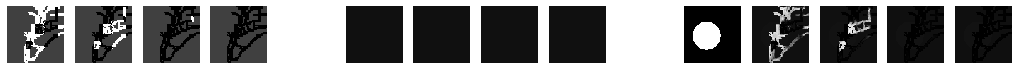

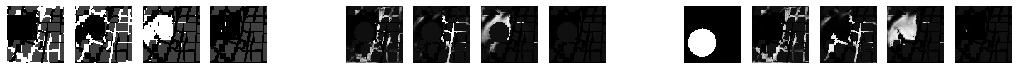

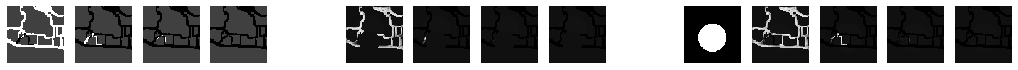

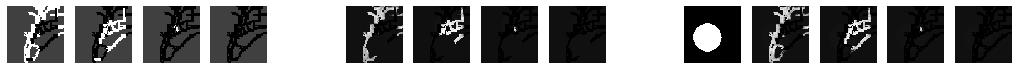

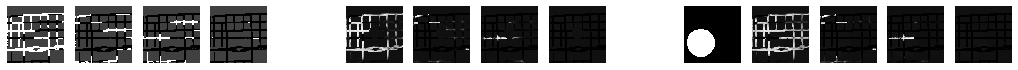

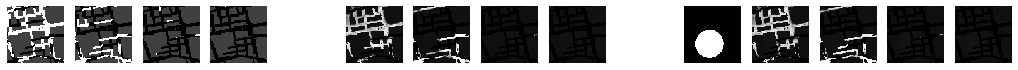

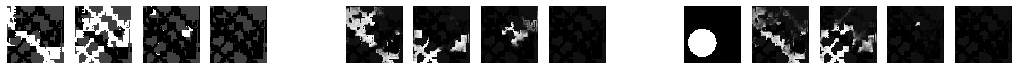

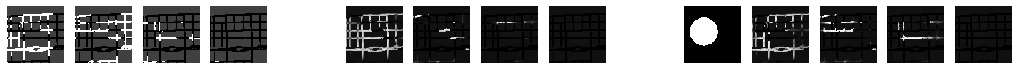

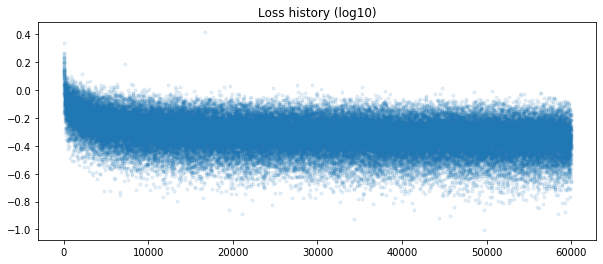

60000 loss = 0.43970730900764465 ave_log_loss -0.3584396852481269
Toal Time Cost: 741.5395 min
Ave Time Cost: 0.0124 min/epoch


In [6]:
# torch.autograd.set_detect_anomaly(True)
loss_log = []

def plot_loss(loss_log):
    plt.figure(figsize=(10, 4))
    plt.title('Loss history (log10)')
    plt.plot(np.log10(loss_log), '.', alpha=0.1)
    plt.show()
    return

def train(x, target, valid_mask_t, calibration_map, steps, optimizer, scheduler):
    for _ in range(steps):
        x = my_model(x, valid_mask_t, 1)
        h = torch.softmax(x[..., :ALPHA_CHANNEL], -1)
        t = target[..., :ALPHA_CHANNEL]
        _delta = t*(h-1)
        delta = _delta * calibration_map * CALIBRATION
        y1 = x[..., :ALPHA_CHANNEL]-delta
        
        alpha_h = x[..., ALPHA_CHANNEL:(ALPHA_CHANNEL+1)]
        y2 = alpha_h - 2 * (alpha_h-valid_mask_t) * calibration_map * CALIBRATION
        x = torch.cat((y1,y2,x[..., (ALPHA_CHANNEL+1):]), -1)
    
    loss_kldiv, loss_alpha = loss_f(x, target)
    loss_kldiv, loss_alpha = torch.mean(loss_kldiv), torch.mean(loss_alpha)
    loss = loss_kldiv+loss_alpha
    print(loss_kldiv.item(), loss_alpha.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    return x, loss

def loss_f(x, target, epsilon=1e-8):
    h = torch.softmax(x[..., :ALPHA_CHANNEL], -1)
    t = target[..., :ALPHA_CHANNEL]
    loss_kldiv = torch.mean(torch.sum(h*torch.log(h/t+epsilon), -1), [-1,-2])
    loss_alpha = torch.mean(torch.pow(x[..., ALPHA_CHANNEL]-target[..., ALPHA_CHANNEL], 2), [-1,-2])
    return loss_kldiv, loss_alpha

starting_time = time.time()
for i_epoch in range(n_epoch+1):
    targets = []
    target_is = []
    for _ in range(BATCH_SIZE):
        d_i = np.random.randint(len(d_trains))
        target_i = np.random.randint(d_trains[d_i].shape[0])
        target_is.append((d_i, target_i))
        target = np.concatenate((d_trains[d_i][target_i:target_i+1], valid_masks[d_i:(d_i+1)]), -1)
        targets.append(target)
    targets = np.concatenate(targets, 0).astype(np.float32)
    targets[..., :-1] += eps
    targets[..., :-1] /= np.sum(targets[..., :-1], axis=-1, keepdims=True)
    _target = torch.from_numpy(targets).to(DEVICE)
    
    calibration_map = make_circle_masks(_target.size(0), map_size[0], map_size[1], rmin=0.5, rmax=0.5)[..., None]
    calibration_map = torch.from_numpy(calibration_map.astype(np.float32)).to(DEVICE)
    
    if USE_PATTERN_POOL:
        batches = []
        batch_x = []
        train_x = []
        for target_index, (d_i, target_i) in enumerate(target_is):
            batch = pools_list[d_i][target_i].sample(1)
            batches.append(batch)
            batch_x.append(batch.x)
            if target_index<(len(target_is)-TRANS_N):
                train_x.append(batch.x)
            else:
                new_target_i = np.random.randint(d_trains[d_i].shape[0])
                batch = pools_list[d_i][new_target_i].sample(1)
                train_x.append(batch.x)
        x0 = np.concatenate(train_x, 0)
        init_coord = get_rand_avail(valid_masks[:1])
        seed = make_seed(map_size, CHANNEL_N, np.arange(CHANNEL_N-ALPHA_CHANNEL)+ALPHA_CHANNEL, init_coord)
        x0[:1] = seed

        if DAMAGE_N:
            damage = 1.0-make_circle_masks(DAMAGE_N, map_size[0], map_size[1])[..., None]
            x0[1:1+DAMAGE_N] *= damage
    else:
        x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)
    x0 = torch.from_numpy(x0.astype(np.float32)).to(DEVICE)
    
    valid_mask_t = valid_masks[[tmp[0] for tmp in target_is]]
    valid_mask_t = torch.from_numpy(valid_mask_t.astype(np.float32)).to(DEVICE)
    
    x, loss = train(x0, _target, valid_mask_t, calibration_map, N_STEPS, optimizer, scheduler)
    
    if USE_PATTERN_POOL:
        for batch_i, batch in enumerate(batches):
            batch.x[:] = x.detach().cpu().numpy()[batch_i:(batch_i+1)]
            batch.commit()

    loss_log.append(loss.item())
    
    if (i_epoch)%50 == 0:
        clear_output()
        
        x0 = x0.detach().cpu().numpy()
        x0 = softmax(x0, -1)
        hyp = x.detach().cpu().numpy()
        hyp = softmax(hyp, -1)
        cali_map_numpy = calibration_map.detach().cpu().numpy()
        
        for i in range(targets.shape[0]):
            plt.figure(figsize=(18,4))
            for j in range(4):
                plt.subplot(1,15,j+1)
                rotated_img = ndimage.rotate(targets[i, ..., j], 90)
                plt.imshow(rotated_img, cmap=plt.cm.gray, vmin=0, vmax=1)
                plt.axis('off')
            # all white
            plt.subplot(1,15,5)
            plt.imshow(np.ones(map_size), cmap='binary', vmin=1, vmax=1)
            plt.axis('off')
            for j in range(4):
                plt.subplot(1,15,j+6)
                rotated_img = ndimage.rotate(x0[i, ..., j], 90)
                plt.imshow(rotated_img, cmap=plt.cm.gray, vmin=0, vmax=1)
                plt.axis('off')
            # all white
            plt.subplot(1,15,10)
            plt.imshow(np.ones(map_size), cmap='binary', vmin=1, vmax=1)
            plt.axis('off')
            # calibration_map
            plt.subplot(1,15,11)
            rotated_img = ndimage.rotate(cali_map_numpy[i, ..., 0], 90)
            plt.imshow(rotated_img, cmap=plt.cm.gray, vmin=0, vmax=1)
            plt.axis('off')
            for j in range(4):
                plt.subplot(1,15,j+12)
                rotated_img = ndimage.rotate(hyp[i, ..., j], 90)
                plt.imshow(rotated_img, cmap=plt.cm.gray, vmin=0, vmax=1)
                plt.axis('off')
            plt.show()

        plot_loss(loss_log)
        total_time_cost = np.round((time.time()-starting_time)/60, 4)
        ave_time_cost = np.round((time.time()-starting_time)/60/(i_epoch+1), 4)
        
        print(i_epoch, "loss =", loss.item(), "ave_log_loss", np.log(np.mean(loss_log[-100:]))/np.log(10))
        print("Toal Time Cost:", total_time_cost, "min")
        print("Ave Time Cost:", ave_time_cost, "min/epoch")
        torch.save(my_model.state_dict(), model_path)

In [7]:
np.save("loss_logs/loss_log_train_2_hidden_16_pool", loss_log)